In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import pandas as pd
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [2]:
path_to_data = r'/Users/noahstanis/Documents/24 Spring quarter/CSE 599 AI for Neuroscience/final project/CSE599_data.pkl'
data = pd.read_pickle(path_to_data).dropna()
data

,date,stim,angle,inform theta A3,inform theta A5,inform theta A6,inform theta A12,inform theta A14,inform theta B3,inform theta B4,...,move hg3 A6,move hg3 A12,move hg3 A14,move hg3 B3,move hg3 B4,move hg3 B5,move hg3 B6,move hg3 B12,move hg3 B13,move hg3 B16
0,2021-11-15,1,90,2767.058769,3319.577140,1598.683546,1835.240369,4661.079116,1553.194879,238.416317,...,0.019960,0.021739,0.052374,0.019361,0.005314,0.027500,0.007524,0.033852,0.002961,0.043641
1,2021-11-15,0,360,104.255676,77.883471,131.180743,30.436747,97.835145,17.705533,16.494238,...,0.000511,0.000794,0.000422,0.000738,0.000873,0.000634,0.000790,0.000423,0.000483,0.000498
2,2021-11-15,0,270,50.150293,45.327700,51.920366,32.971029,47.178743,24.481136,23.102153,...,0.000756,0.000774,0.000698,0.000727,0.000629,0.000709,0.000844,0.000582,0.000575,0.000678
3,2021-11-15,1,180,3062.375759,3277.085984,1758.470990,1659.383445,4976.446367,1515.910051,178.259006,...,0.001481,0.002181,0.002937,0.002050,0.001511,0.001895,0.001670,0.002351,0.000655,0.002700
4,2021-11-15,1,90,3162.540746,3293.016385,1680.266837,1662.085155,4950.645708,1550.942740,223.833651,...,0.000617,0.000723,0.002043,0.000387,0.000687,0.000930,0.001235,0.001882,0.000684,0.002123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,2021-11-17,1,90,3533.357569,5335.825708,3787.332218,2801.347717,7303.050300,2430.308162,195.150881,...,0.001427,0.000947,0.001290,0.000906,0.000600,0.000735,0.001189,0.001319,0.000609,0.000828
1034,2021-11-17,1,180,3653.666805,5460.681404,3912.295809,2852.188620,7275.477266,2427.235555,192.783265,...,0.000982,0.000686,0.001463,0.000632,0.000859,0.000653,0.001357,0.002504,0.000480,0.000864
1035,2021-11-17,1,360,2210.131825,3460.735719,2300.639411,1699.945210,4737.534607,1360.639129,119.452321,...,0.002464,0.001497,0.000932,0.001163,0.000865,0.000840,0.002297,0.000550,0.001080,0.000752
1036,2021-11-17,0,180,10.937448,8.520922,11.501547,9.964744,12.844933,5.909308,3.972222,...,0.000472,0.000376,0.000607,0.000423,0.000448,0.000488,0.000472,0.000437,0.000372,0.000726


In [3]:
# 2021-11-15
oneday_data = data[data['date'] == '2021-11-15']

# NO stim data - 2021-11-15
#no_stim_data = data[data['stim'] == 0]
#oneday_data = no_stim_data[no_stim_data['date'] == '2021-11-15']

# Stim data - 2021-11-15                        
#stim_data = data[data['stim'] == 1]
#oneday_data = stim_data[stim_data['date'] == '2021-11-15']

names = data.columns

# stim_inputs =stim_oneday_data[names[3:]]
# stim_inputs = torch.tensor(stim_inputs.values).to(torch.float32)

# Inputs to nerual network (tf power features)
pd_inputs = oneday_data[names[3:]] # 87 for move epoch only 
inputs = torch.tensor(pd_inputs.values)
inputs = inputs.to(torch.float32)

# target of nerual netwokr (reach direction)
angle_outputs = oneday_data['angle'].values
outputs = torch.zeros(angle_outputs.shape[0], 4, dtype = torch.long)

# Transofrm inputs into binary form
for i in range(angle_outputs.shape[0]):
    ind = angle_outputs[i]/90 -1
    outputs[i, int(ind)] = 1


ind_list = torch.argmax(outputs, dim = 1)
print(torch.sum(ind_list == 0)) # 90
print(torch.sum(ind_list == 1)) # 180
print(torch.sum(ind_list == 2)) # 270
print(torch.sum(ind_list == 3)) # 360


tensor(136)
tensor(120)
tensor(114)
tensor(113)


In [4]:
class RNN(nn.Module):
    def __init__(self, input_size,  hidden_size, output_size, nonlinearity = 'tanh'):

        super(RNN, self).__init__()
        #self.hidden_size = hidden_size[0]
        # self.layer1 = nn.Linear(input_size, hidden_size[0])
        #self.layer2 = nn.Linear(hidden_size[0], hidden_size[1])
        #self.layer3 = nn.Linear(hidden_size[1], output_size)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers = 5, nonlinearity = 'tanh')
        self.out_layer = nn.Linear(hidden_size, output_size)
        self.logsoftmax = nn.Softmax(dim = 1)


    def forward(self, x):
        # rnn_out = torch.squeeze(rnn_out)
        # print(rnn_out.shape)

       # hidden1 = F.tanh(self.layer1(x))
        #hidden2 = F.tanh(self.layer2(hidden1))
        # hidden2 = F.tanh(self.layer2(hidden1))
        # output  = F.relu(self.layer3(hidden2))
        # = self.layer4(hidden3)

        #output = F.softmax(self.layer3(hidden2), dim = 1)
       
        hidden1, _ = self.rnn(x)
        output = self.out_layer(hidden1)
        output = self.logsoftmax(output)
       
        return  output, hidden1

    def initHidden(self):
        return torch.rand(1, self.hidden_size)
    

In [5]:
class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [6]:
def train_model(model, loader, optimizer, loss_fn, epochs, threshold): 

    loss_list = []
    grad_list = []



    for epoch in range(epochs):
        total_loss = 0
        total_grad = 0
        prev_loss = 0
        for batch_idx, batch in enumerate(loader):
        
            inputs, target = batch
            optimizer.zero_grad()
            # print(input.shape)
        
            output, _ = model(inputs)
            # print(output.shape)
            loss = 0
            for l in range(output.shape[0]):
                loss+= loss_fn(output[l, :].double(), target[l, :].double())
            

            # loss = loss_fn(output, target)
            total_loss += loss.item()
            loss.backward()
            # grad = np.mean([p.grad.norm() for p in model.parameters()])
           

            # torch.nn.utils.clip_grad_norm_(model.parameters(), threshold)
            optimizer.step()

            if abs(prev_loss - loss) <= 1e-6:
                break
            else:
                prev_loss = loss

                
        if epoch % 500 == 0: 
            # print(epoch % 1000)
            print("Epoch:" + str(epoch))
            print("loss: " + str(loss.item()))
            

        loss_list.append(total_loss / len(loader))


    return loss_list, model

In [7]:
def test_model(model, inputs, targets):

    outputs, _ = model(inputs)
    # print(outputs)
    pred = torch.argmax(outputs, dim = 1)
    # print(pred)
    targets_pos = torch.argmax(targets, dim = 1)

    pred_acc = torch.sum(pred == targets_pos) / inputs.shape[0]
    


    return pred_acc, targets_pos, pred



In [8]:
input_size = len(pd_inputs.columns)
output_size = 4
hidden_size = 155 # Original code = 55
learning_rate = 1e-4
decay = 0.1
batch_size = 10
net =  RNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(net.parameters(), lr = learning_rate, weight_decay = decay)
loss_fn = nn.CrossEntropyLoss()
dataset = MyDataset(inputs, outputs)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True) 



In [9]:
epochs = 2000
threshold = 1
avg_loss, net = train_model(net, loader, optimizer, loss_fn, epochs, threshold)


Epoch:0
loss: 4.11744651069899
Epoch:500
loss: 2.423938708336404
Epoch:1000
loss: 3.7410289306178917
Epoch:1500
loss: 3.755502872340652


Text(0, 0.5, 'Average Loss')

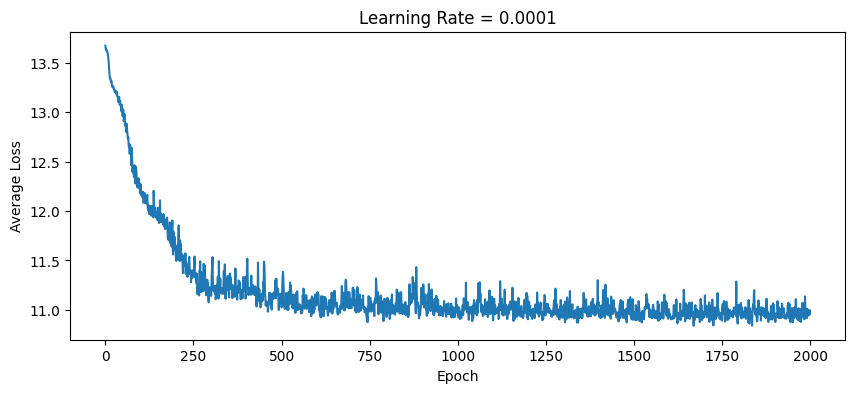

In [10]:
plt.figure(figsize=(10, 4))
plt.title("Learning Rate = " + str(learning_rate))

plt.plot(avg_loss)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

# plt.show()
# plt.savefig("loss_n_grad_lr_" + str(learning_rate)+".png")

In [11]:
def prediction_details(pred, target, pred_acc):
    matrix = np.zeros((4, 4))
    for i in range(pred.shape[0]):
        matrix[pred[i], target[i]] += 1
    print(matrix)
    matrix = matrix / np.sum(matrix, 1)
    plt.figure
    plt.title("Prediciton accuracy = " + str(round(pred_acc.item(), 3)))
    plt.imshow(matrix)
    
    plt.colorbar()

tensor(0.6377)
[[112.  39.  47.  42.]
 [ 21.  78.   8.  12.]
 [  1.   2.  59.   0.]
 [  2.   1.   0.  59.]]
tensor([0, 3, 2, 1, 0, 0, 2, 2, 3, 3, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 2, 1,
        1, 1, 0, 3, 3, 1, 2, 3, 0, 3, 0, 1, 1, 2, 0, 1, 3, 2, 2, 3, 1, 0, 2, 2,
        0, 2, 0, 3, 2, 0, 2, 1, 0, 1, 0, 2, 1, 2, 2, 1, 1, 2, 3, 2, 0, 2, 2, 0,
        0, 1, 2, 2, 3, 1, 1, 1, 0, 1, 0, 1, 2, 0, 2, 1, 3, 3, 2, 2, 0, 3, 2, 3,
        3, 2, 0, 3, 1, 2, 1, 2, 0, 2, 3, 3, 0, 3, 0, 1, 0, 1, 2, 3, 2, 3, 0, 3,
        0, 1, 1, 2, 3, 1, 3, 0, 0, 3, 2, 0, 0, 3, 1, 1, 1, 0, 0, 3, 2, 2, 2, 1,
        2, 3, 2, 1, 1, 1, 1, 2, 3, 1, 3, 2, 0, 0, 0, 0, 0, 1, 0, 3, 1, 2, 0, 0,
        2, 2, 0, 0, 1, 0, 2, 1, 1, 0, 3, 1, 0, 3, 1, 0, 2, 2, 2, 1, 0, 3, 2, 3,
        0, 3, 3, 1, 2, 3, 1, 0, 0, 0, 2, 3, 0, 0, 1, 2, 1, 3, 0, 2, 0, 1, 2, 1,
        3, 1, 2, 0, 2, 0, 1, 3, 0, 2, 2, 1, 3, 3, 0, 2, 1, 3, 1, 1, 3, 0, 3, 2,
        2, 2, 3, 1, 1, 3, 0, 3, 2, 1, 3, 3, 1, 0, 0, 1, 1, 3, 1, 0, 3, 2, 0, 3,
        3, 2

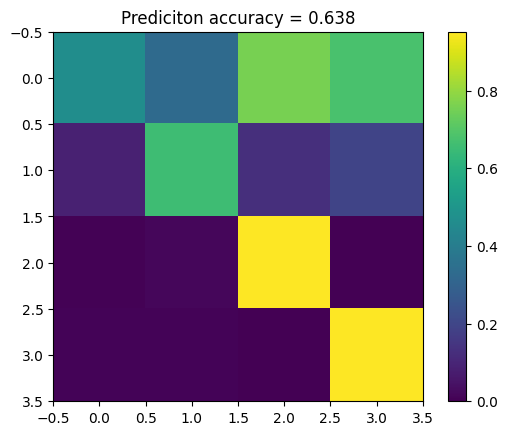

In [12]:
pred_acc, target_pos, pred = test_model(net, inputs, outputs)
print(pred_acc)
prediction_details(pred, target_pos, pred_acc)
# plt.savefig("prediction_accuracy.png")
print(target_pos)
print(outputs)

In [13]:
pred_output_state, hidden_states = net(inputs)

In [14]:
# use LDA to find two hidden units that best separate the four classes
output_ind = torch.argmax(outputs, dim = 1).detach().numpy()
unit1 = 0
unit2 = 0
max_acc = 0
n_hidden_units = hidden_states.shape[1]
for k in range(n_hidden_units-1):
    for j in range(k+1, n_hidden_units):
        clf = LDA()
        units = hidden_states[:, [k, j]].detach().numpy()
        clf.fit(units,  output_ind)
        lda_pred = clf.predict(units)
        lda_acc = np.sum(lda_pred == output_ind)/output_ind.shape[0]
        if lda_acc > max_acc:
            unit1 = k
            unit2 = j
            max_acc = lda_acc


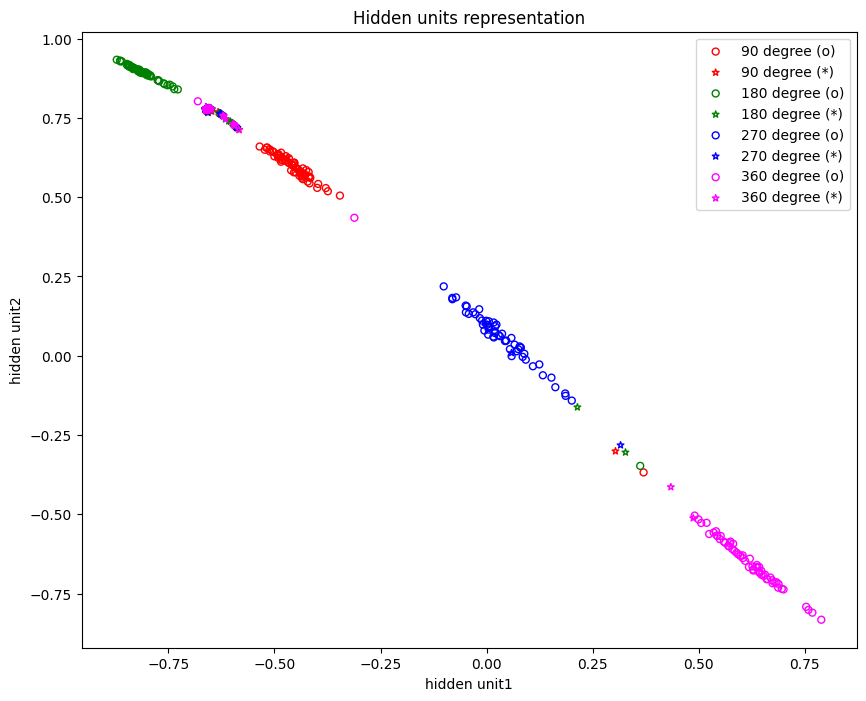

In [15]:
# Define color and symbol lists
hiddens = hidden_states.detach().numpy()
color_list = ['red', 'green', 'blue', 'magenta']
symbol_list = ['o', '*']
stim_labels = np.array(oneday_data['stim'])

plt.figure(figsize=(10, 8))

# Plot for each combination of label and stim_label
for label in range(4):
    for stim in [0,1]:  # Assuming stim_labels has values 0 and 1
        ind = (output_ind == label) & (stim_labels == stim)
        plt.scatter(hiddens[ind, unit1], hiddens[ind, unit2], s=25, facecolors='none', 
                    edgecolors=color_list[label], marker=symbol_list[stim])

# Set legend
plt.legend(["90 degree (o)", "90 degree (*)", "180 degree (o)", "180 degree (*)", 
            "270 degree (o)", "270 degree (*)", "360 degree (o)", "360 degree (*)"], loc='best')
plt.xlabel("hidden unit1")
plt.ylabel("hidden unit2")
plt.title("Hidden units representation")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

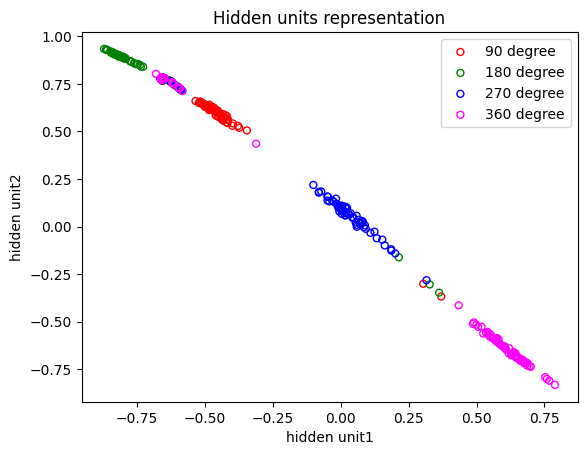

In [16]:
# Sophia's old code 
hidden_states.shape
plt.figure
hiddens = hidden_states.detach().numpy()

output_ind = torch.argmax(outputs, dim = 1).detach().numpy()
color_list = ['red', 'green', 'blue', 'magenta']
symbol_list = ['o','*']
for label in range(4):
    ind = output_ind == label
    plt.scatter(hiddens[ind, unit1], hiddens[ind, unit2], s = 25, facecolors='none', edgecolors=color_list[label])
    plt.legend(["90 degree", "180 degree", "270 degree", "360 degree"])
    plt.xlabel("hidden unit1")
    plt.ylabel("hidden unit2")
    plt.title("Hidden units representation")
plt.show
#plt.savefig("hidden_unit_rep.png")
